In [5]:
from data_utils import (
    DATA_DIR,
    load_labels,
    aug_crossentropy_RI_Dataset,
    AddGaussianNoise,
    crossentropy_RI_Dataset,
    RI_Dataset,
    find_file,
)
from network_def_crossentropy import CNN, CNN_small
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision.transforms.v2 as tvtf
import numpy as np
import torchinfo
import xarray as xr

In [9]:
dropout_rate = 0.5
device = "cpu"

In [129]:
rotate_transform = tvtf.RandomRotation(50)
noise_transform = AddGaussianNoise(std=0.5)
translate_transform = tvtf.RandomAffine(0, translate=(0.05, 0.05))

transform_list = (
    [rotate_transform] * 2 + [translate_transform] * 2 + [noise_transform] * 3
)

valid_labels, _ = load_labels(DATA_DIR + '/valid_labels.json')
train_labels, train_weights = load_labels(DATA_DIR + '/train_labels.json')
cnn_valid_ds = aug_crossentropy_RI_Dataset(valid_labels)

batch_size = 16*2
cnn_valid_dataloader = DataLoader(cnn_valid_ds, num_workers=1, batch_size=batch_size)

In [136]:
valid_ds2 = RI_Dataset(valid_labels)
valid_loader_2 = DataLoader(valid_ds2, num_workers=1, batch_size=batch_size)

In [137]:
ds1 = iter(cnn_valid_dataloader)
ds2 = iter(valid_loader_2)

In [138]:
X1, y1 = next(ds1)
X2, y2 = next(ds2)

In [140]:
y1.shape

torch.Size([32, 1])

In [4]:
import xarray as xr

In [5]:
find_file(DATA_DIR, 'storm0')

AssertionError: cyclone_id_string must be length 8; got 6

In [107]:
ds = xr.open_dataset(find_file(DATA_DIR, 'storm100'))

In [110]:
X_raw = ds.sel(satellite_valid_time_unix_sec=9)
X = torch.tensor(X_raw.satellite_predictors_gridded.values.astype(np.float32))

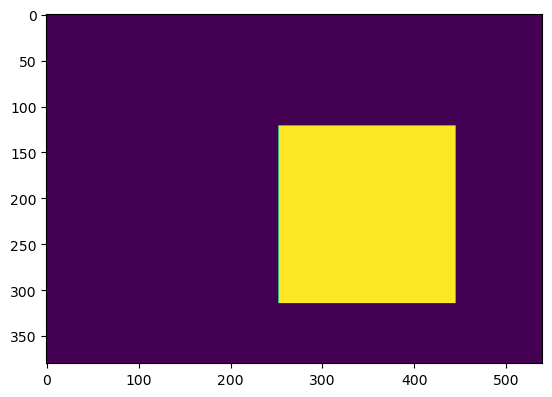

In [111]:
plt.imshow(X)

In [106]:
valid_labels[0:20]

array([['storm0', '0', 0],
       ['storm0', '1', 0],
       ['storm0', '2', 1],
       ['storm0', '3', 0],
       ['storm0', '4', 0],
       ['storm0', '5', 0],
       ['storm0', '6', 0],
       ['storm0', '7', 0],
       ['storm0', '8', 0],
       ['storm0', '9', 1],
       ['storm0', '10', 0],
       ['storm0', '11', 0],
       ['storm0', '12', 0],
       ['storm0', '13', 0],
       ['storm0', '14', 1],
       ['storm0', '15', 0],
       ['storm0', '16', 1],
       ['storm0', '17', 0],
       ['storm0', '18', 0],
       ['storm0', '19', 0]], dtype=object)

In [13]:
test_ds = iter(cnn_valid_ds)

In [4]:
i = 0

In [7]:
y.shape

torch.Size([8])

In [22]:
test_dataloader = iter(cnn_valid_dataloader)

In [26]:
X, y = next(test_dataloader)
X = X.view(-1, 1, 380, 540)
y = y.view(-1)

In [28]:
i = 0

tensor(0)


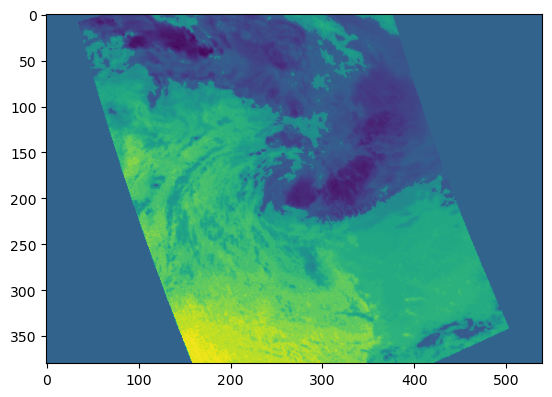

In [93]:
print(y[i])
plt.imshow(X[i, 0, ...])
i += 1

tensor([0, 0, 0, 0, 0, 0, 0, 0])


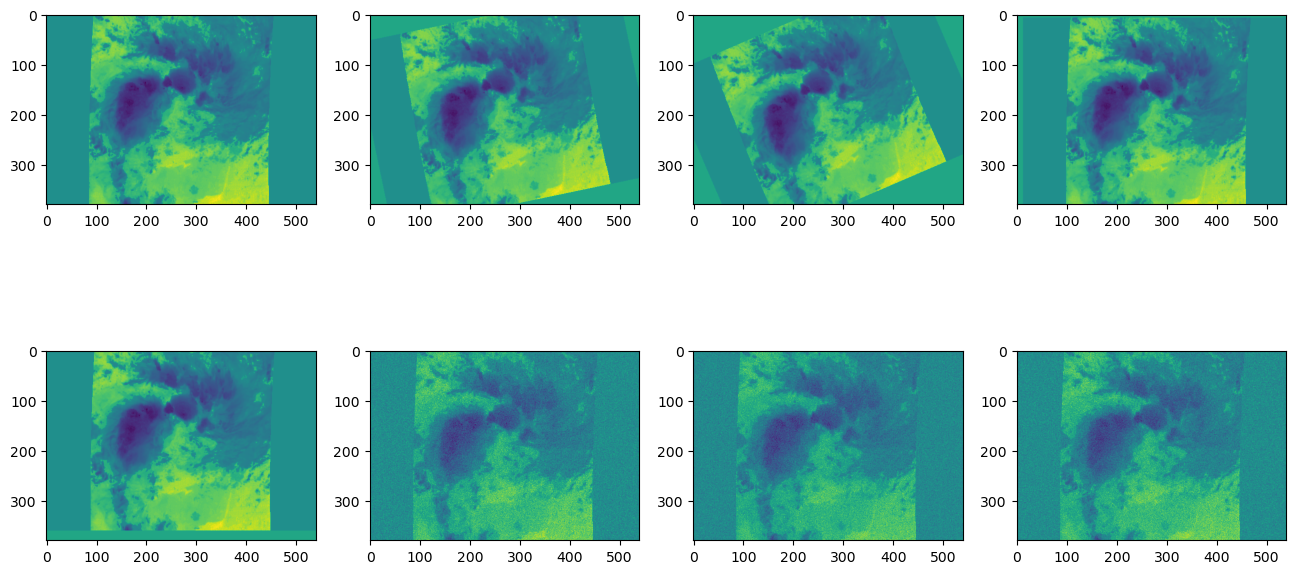

In [12]:
X, y = cnn_valid_ds.__getitem__(i)
print(y)
F, ax = plt.subplots(2, 4, figsize=(16, 8))
raveled_ax = np.ravel(ax)
for j in range(8):
    raveled_ax[j].imshow(X[j, 0, ...])
i += 1

tensor([0, 0, 0, 0, 0, 0, 0, 0])


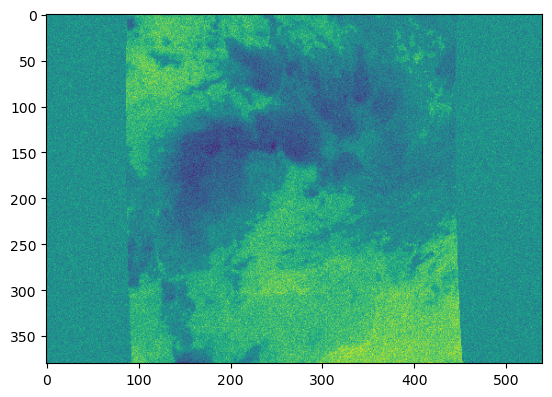

In [21]:
X, y = next(test_ds)
plt.imshow(X[7, 0, ...])
print(y)

In [6]:
train_labels, train_weights = load_labels(DATA_DIR + '/train_labels.json')
cnn_train_ds = crossentropy_RI_Dataset(train_labels)

batch_size = 16*2
wtd_sampler = WeightedRandomSampler(train_weights, len(train_labels), replacement=True)
cnn_train_dataloader = DataLoader(cnn_train_ds, num_workers=1, batch_size=batch_size, sampler=wtd_sampler)

In [7]:
valid_labels, _ = load_labels(DATA_DIR + '/valid_labels.json')
cnn_valid_ds = aug_crossentropy_RI_Dataset(valid_labels)

batch_size = 16*2
cnn_valid_dataloader = DataLoader(cnn_valid_ds, num_workers=1, batch_size=batch_size)

In [10]:
cnn_model = CNN(dropout_rate=dropout_rate)
cnn_model.load_state_dict(
    torch.load(
        "./saved_models/crossentropy_cnn.pt", map_location=torch.device("cpu")
    )
)
cnn_model.eval()

CNN(
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
      (1): ReLU()
      (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
      (1): ReLU()
      (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
      (3): ReLU()
      (4): MaxPool2d(k

In [11]:
torchinfo.summary(cnn_model, (32, 1, 380, 540))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 2]                   --
├─Sequential: 1-1                        [32, 256, 5, 8]           --
│    └─Sequential: 2-1                   [32, 8, 190, 270]         --
│    │    └─Conv2d: 3-1                  [32, 8, 380, 540]         80
│    │    └─ReLU: 3-2                    [32, 8, 380, 540]         --
│    │    └─Conv2d: 3-3                  [32, 8, 380, 540]         584
│    │    └─ReLU: 3-4                    [32, 8, 380, 540]         --
│    │    └─MaxPool2d: 3-5               [32, 8, 190, 270]         --
│    └─Sequential: 2-2                   [32, 16, 95, 135]         --
│    │    └─Conv2d: 3-6                  [32, 16, 190, 270]        1,168
│    │    └─ReLU: 3-7                    [32, 16, 190, 270]        --
│    │    └─Conv2d: 3-8                  [32, 16, 190, 270]        2,320
│    │    └─ReLU: 3-9                    [32, 16, 190, 270]        --
│    │  

In [12]:
test_iterator = iter(cnn_valid_dataloader)

In [13]:
test_vals = next(test_iterator)
test_input = torch.reshape(test_vals[0], (-1, 1, 380, 540))
test_target = torch.reshape(test_vals[1], (-1,))
print(test_input.shape)
print(test_target.shape)
with torch.no_grad():
    test_output = cnn_model(test_input)
print(test_output.shape)
print(test_output.argmax(dim=1))
print(test_target)

torch.Size([32, 1, 380, 540])
torch.Size([32])


In [166]:
test_input.mean()

tensor(0.0226)

In [17]:
train_labels, train_weights = load_labels(DATA_DIR + '/train_labels.json')
rotate_transform = tvtf.RandomRotation(50)
noise_transform = AddGaussianNoise(std=0.5)
translate_transform = tvtf.RandomAffine(0, translate=(0.1, 0.1))
transform_list = [
    rotate_transform,
    rotate_transform,
    translate_transform,
    translate_transform,
    noise_transform,
    noise_transform,
    noise_transform,
]
cnn_train_ds = aug_crossentropy_RI_Dataset(train_labels)

num_batches = 32
batch_size = 16
wtd_sampler = WeightedRandomSampler(train_weights, num_batches*batch_size, replacement=True)
cnn_train_dataloader = DataLoader(cnn_train_ds, num_workers=1, batch_size=batch_size, sampler=wtd_sampler)

In [18]:
train_iter = iter(cnn_train_dataloader)

In [19]:
train_input, train_target = next(train_iter)

In [24]:
train_target.shape

torch.Size([16, 1])

In [12]:
train_target = train_target.view(-1)

In [21]:
train_input.shape

torch.Size([16, 1, 1, 380, 540])

In [22]:
train_input_reshape = train_input.view(-1, 1, 380, 540)

In [23]:
train_input_reshape.shape

torch.Size([16, 1, 380, 540])

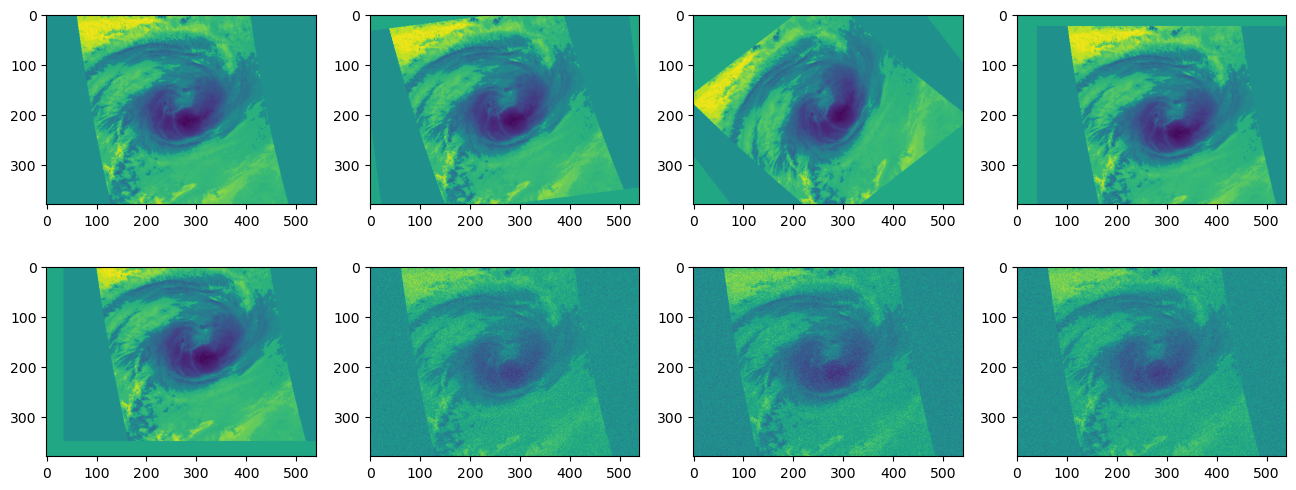

In [54]:
F, axs = plt.subplots(2, 4, figsize=(16, 6))
for i, ax in enumerate(np.ravel(axs)):
    ax.imshow(train_input[0, i, 0, ...])

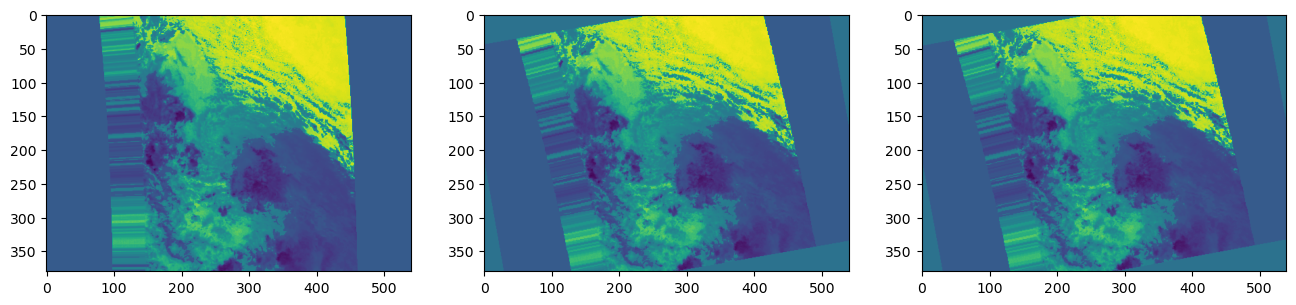

In [34]:
F, ax = plt.subplots(1, 3, figsize=(16, 6))
for i in range(3):
    ax[i].imshow(train_input_reshape[i, 0, ...])

In [11]:
import data_utils as du
import generate_labels as gen_labels

tc_list = du.find_cyclones(du.DATA_DIR)

In [5]:
tc_list[0:10]

['1993AL01',
 '1993AL02',
 '1993AL03',
 '1993AL04',
 '1993AL05',
 '1993AL06',
 '1993AL07',
 '1993AL08',
 '1993AL09',
 '1993AL10']

In [6]:
tc_id = tc_list[7]
tc_id

'1993AL08'

In [9]:
ds = xr.open_dataset(du.find_file(du.DATA_DIR, tc_id))

In [10]:
ds

<xarray.Dataset>
Dimensions:                                          (
                                                      satellite_valid_time_unix_sec: 297,
                                                      satellite_grid_row: 380,
                                                      satellite_grid_column: 540,
                                                      satellite_predictor_name_gridded: 1,
                                                      satellite_predictor_name_ungridded: 16,
                                                      ...
                                                      ships_storm_object_index: 29,
                                                      ships_forecast_hour: 23,
                                                      ships_intensity_threshold_m_s01: 21,
                                                      ships_lag_time_hours: 5,
                                                      ships_predictor_name_lagged: 17,
                                                      ships_predictor_name_forecast: 129)
Coordinates:
  * satellite_grid_row                               (satellite_grid_row) int32 ...
  * satellite_grid_column                            (satellite_grid_column) int32 ...
  * satellite_valid_time_unix_sec                    (satellite_valid_time_unix_sec) int32 ...
  * ships_forecast_hour                              (ships_forecast_hour) int32 ...
  * ships_intensity_threshold_m_s01                  (ships_intensity_threshold_m_s01) float64 ...
  * ships_lag_time_hours                             (ships_lag_time_hours) float64 ...
  * satellite_predictor_name_gridded                 (satellite_predictor_name_gridded) object ...
  * satellite_predictor_name_ungridded               (satellite_predictor_name_ungridded) object ...
  * ships_valid_time_unix_sec                        (ships_valid_time_unix_sec) int32 ...
  * ships_predictor_name_lagged                      (ships_predictor_name_lagged) object ...
  * ships_predictor_name_forecast                    (ships_predictor_name_forecast) object ...
Dimensions without coordinates: ships_storm_object_index
Data variables: (12/41)
    satellite_number                                 (satellite_valid_time_unix_sec) int32 ...
    satellite_band_number                            (satellite_valid_time_unix_sec) int32 ...
    satellite_band_wavelength_micrometres            (satellite_valid_time_unix_sec) float64 ...
    satellite_longitude_deg_e                        (satellite_valid_time_unix_sec) float64 ...
    satellite_cyclone_id_string                      (satellite_valid_time_unix_sec) |S8 ...
    satellite_storm_type_string                      (satellite_valid_time_unix_sec) |S2 ...
    ...                                               ...
    ships_v_motion_optimal_flow_m_s01                (ships_storm_object_index) float64 ...
    ships_cyclone_id_string                          (ships_storm_object_index) object ...
    ships_storm_latitude_deg_n                       (ships_storm_object_index) float64 ...
    ships_storm_longitude_deg_e                      (ships_storm_object_index) float64 ...
    ships_predictors_lagged                          (ships_valid_time_unix_sec, ships_lag_time_hours, ships_predictor_name_lagged) float64 ...
    ships_predictors_forecast                        (ships_valid_time_unix_sec, ships_forecast_hour, ships_predictor_name_forecast) float64 ...

In [12]:
labeled_storm = gen_labels.label_single_storm(tc_id)

In [14]:
len(labeled_storm)

96

In [35]:
labeled_storm

{748029660: 0,
 748031460: 0,
 748047660: 0,
 748049460: 0,
 748051260: 0,
 748053060: 0,
 748069260: 0,
 748071060: 0,
 748072860: 0,
 748090860: 0,
 748092660: 0,
 748096260: 0,
 748112460: 0,
 748114260: 0,
 748116060: 0,
 748117200: 0,
 748134060: 0,
 748135860: 0,
 748137660: 0,
 748139460: 0,
 748155660: 0,
 748157460: 0,
 748159260: 0,
 748177260: 0,
 748179060: 0,
 748182660: 0,
 748198860: 0,
 748200660: 0,
 748202460: 0,
 748204260: 0,
 748220460: 0,
 748222260: 0,
 748224060: 0,
 748225860: 0,
 748242060: 0,
 748243860: 0,
 748245660: 0,
 748263660: 0,
 748265460: 0,
 748269060: 0,
 748285260: 0,
 748287060: 0,
 748288860: 0,
 748290660: 0,
 748306860: 0,
 748308660: 0,
 748310460: 0,
 748328460: 0,
 748330260: 0,
 748332060: 0,
 748350060: 0,
 748351860: 0,
 748355460: 0,
 748371660: 0,
 748373460: 0,
 748375260: 0,
 748377060: 0,
 748395060: 0,
 748396860: 0,
 748398660: 0,
 748414860: 0,
 748416660: 0,
 748418460: 1,
 748436460: 0,
 748438260: 0,
 748441860: 1,
 748458060

In [16]:
(ds["satellite_valid_time_unix_sec"].max() - ds["satellite_valid_time_unix_sec"].min()) / 3600

<xarray.DataArray 'satellite_valid_time_unix_sec' ()>
array(167.5)

In [18]:
(ds["ships_valid_time_unix_sec"].max() - ds["ships_valid_time_unix_sec"].min()) / 3600

<xarray.DataArray 'ships_valid_time_unix_sec' ()>
array(168.)

In [22]:
ref_intensities = []
valid_intensities = []
for sat_time in ds.satellite_valid_time_unix_sec:
    time_diffs = ds.ships_valid_time_unix_sec.values - sat_time.item()
    if np.abs(time_diffs).min() <= 3600:
        ships_time = ds.ships_valid_time_unix_sec[np.argmin(np.abs(time_diffs))]
        valid_times = ds.ships_valid_time_unix_sec[
            (0 <= time_diffs) & (time_diffs <= 24 * gen_labels.HRS_TO_SECS)
        ]

        ref_intensity = ds["ships_storm_intensity_m_s01"].sel(
            ships_valid_time_unix_sec=ships_time
        )
        valid_intensity = [
            ds["ships_storm_intensity_m_s01"].sel(ships_valid_time_unix_sec=t).values()
            for t in valid_times
        ]

        ref_intensities.append(ref_intensity)
        valid_intensities.append(valid_intensity)

In [37]:
for i in range(len(labeled_storm)):
    print(f"Label: {list(labeled_storm.values())[i]}")
    print(f"Reference Intensity: {ref_intensities[i].item()}")
    print(f"Valid intensities: {valid_intensities[i]}\n")

Label: 0
Reference Intensity: 12.861111111111112


AttributeError: 'list' object has no attribute 'values'

In [142]:
from network_def import crps_loss
import numpy as np

In [144]:
test_target = torch.tensor(np.ones((32,), dtype=np.float32))
test_preds = torch.tensor(np.zeros((32, 100), dtype=np.float32))

In [146]:
loss = crps_loss()

In [147]:
loss(test_preds, test_target)

tensor(0.)